<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/acgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The generator generates an output image given a class label, discriminator judges the output and produces a probability and label.




[**Conditional Image Synthesis With Auxiliary Classifier GANs**
](https://arxiv.org/abs/1610.09585)

![alt text](https://blobs.gitbook.com/assets%2F-LRrOFNeUGLZef_2NLZ0%2F-LeD0FZoGzCVqWjueZJh%2F-LeE9F6Hkew9ZaHTRs6y%2Facgan-3.png?alt=media&token=179bef4a-3f88-4517-90db-4544621bb078)

[Reference](https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/chapter-4-conditional-generative-adversarial-network/acgan-architectural-design)


In [0]:
!mkdir saved_model

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

!mkdir images
!mkdir saved_model

Using TensorFlow backend.


mkdir: cannot create directory ‘saved_model’: File exists


In [0]:
class ACGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

In [0]:
def build_generator(self):

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(self.latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

    model_input = multiply([noise, label_embedding]) #combines label and noise
    img = model(model_input)

    return Model([noise, label], img)

ACGAN.build_generator = build_generator
del build_generator

In [0]:
def build_discriminator(self):

    model = Sequential()

    model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.summary()

    img = Input(shape=self.img_shape)

    # Extract feature representation
    features = model(img)

    # Determine validity and label of the image
    validity = Dense(1, activation="sigmoid")(features)
    label = Dense(self.num_classes, activation="softmax")(features)

    return Model(img, [validity, label])

ACGAN.build_discriminator = build_discriminator
del build_discriminator

In [0]:

def train(self, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Configure inputs
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

        # The labels of the digits that the generator tries to create an
        # image representation of
        sampled_labels = np.random.randint(0, 10, (batch_size, 1))

        # Generate a half batch of new images
        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Image labels. 0-9 
        img_labels = y_train[idx]

        # Train the discriminator
        d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
        d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, sampled_labels])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator
        g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            self.save_model()
            self.sample_images(epoch)

ACGAN.train = train
del train

In [0]:

def sample_images(self, epoch):
    r, c = 10, 10
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    sampled_labels = np.array([num for _ in range(r) for num in range(c)])
    gen_imgs = self.generator.predict([noise, sampled_labels])
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

ACGAN.sample_images = sample_images
del sample_images

In [0]:

def save_model(self):

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    save(self.generator, "generator")
    save(self.discriminator, "discriminator")

ACGAN.save_model = save_model
del save_model

In [0]:
acgan = ACGAN()
acgan.train(epochs=14000, batch_size=32, sample_interval=200)

images/0.png	 images/2000.png  images/3000.png  images/400.png
images/1000.png  images/200.png   images/3200.png  images/600.png
images/1200.png  images/2200.png  images/3400.png  images/800.png
images/1400.png  images/2400.png  images/3600.png
images/1600.png  images/2600.png  images/3800.png
images/1800.png  images/2800.png  images/4000.png


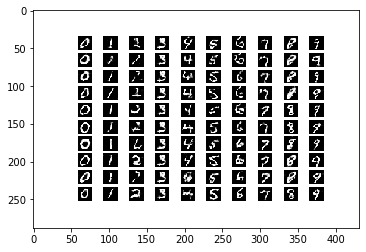

In [0]:
!ls images/*
img = plt.imread("images/4000.png")
plt.imshow(img)